<a href="https://colab.research.google.com/github/AyazNakhudaGitHub/BERT_Customer_Reviews_Classification/blob/main/Yelp_testing_5_categories_long.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yelp Data Testing, 5 Categories, Long Review Texts**

In this notebook, we test the model which utilized the long data that was grouped into 5 categories. The data used for testing is the Yelp dataset provided. The model has never seen this dataset before.

In [ ]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 8.4 MB/s 
     |████████████████████████████████| 596 kB 48.2 MB/s 
     |████████████████████████████████| 1.2 MB 62.1 MB/s 
     |████████████████████████████████| 99 kB 11.9 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 1.1 MB 55.0 MB/s 
     |████████████████████████████████| 213 kB 96.2 MB/s 
     |████████████████████████████████| 47.6 MB 1.2 MB/s 
     |████████████████████████████████| 352 kB 66.3 MB/s 


In [ ]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.9 MB 9.8 MB/s 


In [ ]:
import os
import urllib, json

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from tensorflow.keras.utils import to_categorical

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14103152297645451176
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13362404179809031316
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
yelp_data = pd.read_pickle("small_yelp")

Below we select an equal number of instances from each category.

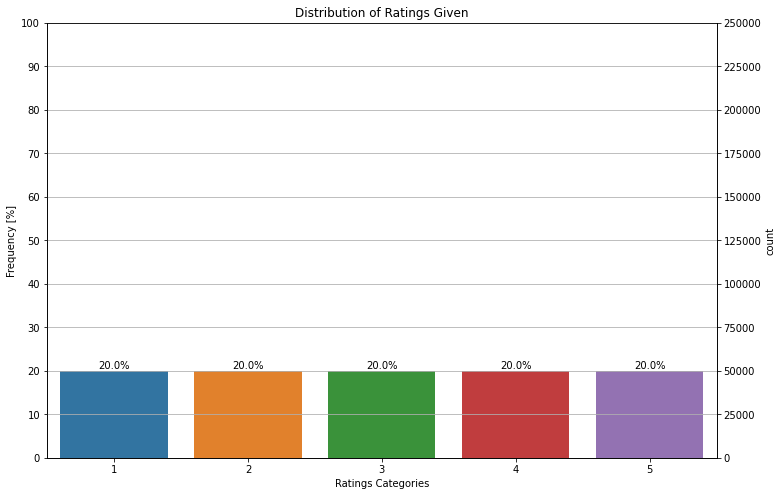

In [ ]:
import seaborn as sns
import matplotlib.ticker as ticker
plt.figure(figsize=(12,8))
ax = sns.countplot(x="stars", data=yelp_data, order=[1,2,3,4,5])
plt.title('Distribution of Ratings Given')
plt.xlabel('Ratings Categories')
ncount = len(yelp_data)
# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

In [ ]:
yelp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 550897 to 2950589
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   stars   250000 non-null  int64 
 1   text    250000 non-null  object
 2   useful  250000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 17.6+ MB


In [ ]:
yelp_data.head(30)

,stars,text,useful
550897,1,I went to this crummy den of rat turds on a bl...,1
515660,1,This body shop is the worst. I would never ta...,0
539261,1,I had one plate and left most of it on there. ...,3
2496804,1,I'm disappointed that I didn't go with lil Cae...,1
4248315,1,Forget the somewhat manufactured-looking decen...,3
3129230,1,Customer service is horrible. Did not know thi...,0
614763,1,Bof - le pizza average et les pâtes - plate du...,1
828025,1,I really was hoping this was a great restauran...,0
1750500,1,"Horrible, trash , bad reception ! Bad attitude...",0
172812,1,"my bad, i wasted my time and breath here AGAIN...",1


In [ ]:
from sklearn.utils import shuffle # shuffling the new data set
yelp_data = shuffle(yelp_data)
yelp_data.reset_index(inplace=True, drop=True)

In [ ]:
yelp_data.head(30)

,stars,text,useful
0,4,The first time I went I was impressed with the...,0
1,2,I ordered the pork bone soup. First all the si...,0
2,4,Pita Jungle is among the tastiest of the tasty...,0
3,3,Nice decor but seating is very intimate. Prof...,0
4,4,I got the Mongolian beef it was very good only...,0
5,5,"excellent, excellent sandwiches. almost too m...",1
6,2,Was excited to see a cafe Rio open in this loc...,4
7,5,Awesome. Awesome. Awesome. This place rocks. ...,0
8,4,Nice stage and fun for small town bands. The g...,2
9,3,I try my best to keep away from fast food and ...,0


In [ ]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
x = yelp_data.text.values
y = yelp_data.stars.values

encoder = LabelEncoder()
encoder.fit(y)

encoded_Y_test = encoder.transform(y)
dummy_y_test = to_categorical(encoded_Y_test)

In [ ]:
max_seq_length = 512


In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))



  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
X_test = bert_encode(x, tokenizer, max_seq_length)

In [ ]:
# load in the model which achieved 81% validation accuracy 
model_fname = 'Ratings_BERT_7'
my_wd = '/content/drive/My Drive'

model = tf.keras.models.load_model(os.path.join(my_wd, model_fname)) 

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test, batch_size=8, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1) + 1
print(classification_report(y, y_pred_bool, labels=[1,2,3,4,5], digits=4))

31250/31250 [==============================] - 5861s 188ms/step
              precision    recall  f1-score   support

           1     0.6821    0.8103    0.7407     50000
           2     0.5755    0.4045    0.4751     50000
           3     0.5632    0.4587    0.5056     50000
           4     0.4769    0.3459    0.4010     50000
           5     0.5692    0.8932    0.6953     50000

    accuracy                         0.5825    250000
   macro avg     0.5734    0.5825    0.5635    250000
weighted avg     0.5734    0.5825    0.5635    250000



In [ ]:
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.5825
